**DA5401: Assignment 4**

*GMM-Based Synthetic Sampling for Imbalanced Data*


**Problem Statement:**

Given a highly imbalanced credit card transaction dataset with the minority class being the fraudulent, use Gaussian Mixture Model (GMM) to generate synthetic samples for the minority class and evaluate the effectiveness to baseline model

### Imports

General Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

Scikit-Learn Imports

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score 

Clustering imports

In [3]:
from sklearn.utils import resample, shuffle
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

Function to provide evaluation metrics along with confusion matrix visualisation

In [4]:
def eval(y_true, y_pred, kind: str= 'test', model_name: str= 'Baseline') -> list:
    """
    Function that returns the accuracy, recall, precision and the f1-metrics for an experiment as
    a list and also displays the classification report and confusion matrix. \n
        INPUT:\n
            y_true: The true labels \n
            y_pred: The model predictions \n
            kind: Whether 'test' or 'train' \n
            model_name: Name of the model \n
        OUTPUT:\n
            A list containing the accuracy, recall, precision and f1-score in that order
    """


    accu = accuracy_score(y_true, y_pred)
    preci = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f'**Results: {model_name} Logistic Regression Model ({kind}ing)**')
    print(f'Overall Accuracy: {accu: .3f}')
    print(f"Precision on 'Fraud' class: {preci: .3f}")
    print(f"Recall on 'Fraud' class: {recall: .3f}")
    print(f"F1-Score on 'Fraud' class: {f1: .3f}")


    print(f'**Classification Report: {model_name} Logistic Regression Model ({kind}ing)**')
    print(classification_report(y_true, y_pred))

    cmd = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels= ['Normal', 'Fraud'])
    cmd.plot(cmap= 'Grays', colorbar= True)
    plt.title(f'Confusion Matrix: {model_name} Logistic Regression Model ({kind}ing)')
    plt.show()

    return [accu, recall, preci, f1]

**Metrics Selected:**

1. Accuracy: Basically the number of correct predictions divided by the total number of predictions for both the classes. As shown later, this metric is a misrepresentation of the actual model performance due to the highly imbalanced dataset.
    
        Accuracy = CorrectPredictions/TotalPredictions


2. Precision: Calculated for the minority class. This is the correct predictions for the class divided by all the predictions for the class. 

        Precision = TP/(TP+FP)

        where TP-> True Positives and FP= False Positives        

3. Recall: Calculated for the minority class. This is the correct predictions for the class divided by all the elements in the class. It can also be understood as the class-accuracy.

        Recall = TP/(TP+FN)

        where TP-> True Positives and FN= False Negatives

4. F1-Score: Calculated for the minority class. It is the harmonic mean of the precision and recall and provides a common metric to evaluate a model's performance, where both precision and recall are weighed the same and thus, is used as a standard metric to evaluate model performance.

        F1-score = 2*Recall*Precision/(Recall + Precision)

## A: Data Exploration and Baseline Model 

Loading the Dataset

In [5]:
df = pd.read_csv('creditcard.csv')
display(df.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class Distribution.

Class '0' indicates Normal and Class '1' indicates Fraud transactions

In [6]:
base_class_dst = df['Class'].value_counts()
print(base_class_dst)

Class
0    284315
1       492
Name: count, dtype: int64


*There is a significant class imbalance, as evident by the count differences, where the fraud transactions are just 492 in comparison to the 284315 normal transactions. The degree of imbalance is high, calculated as*

    DI = Num(Majority)/Num(Minority) = 284315/492 = 577.876

*This is basically an imbalance of 578:1 i.e. for every 578 normal transactions, we have 1 fraud transaction.*

Visualising using a pie chart

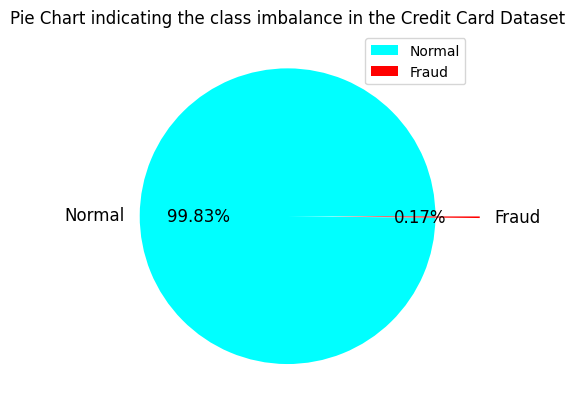

In [7]:
plt.figure()
plt.pie(base_class_dst, labels = ['Normal', 'Fraud'], explode= [0, 0.3],
         autopct= '%1.2f%%', textprops= {'size': 'larger'}, colors= ['cyan', 'red'])
plt.title('Pie Chart indicating the class imbalance in the Credit Card Dataset')
plt.legend()
plt.show()

*As data has already undergone PCA, most features except Time and Amount are preprocessed. While different combinations of scaling were tested, they resulted in obscuring the elbow in elbow curves, making the choice of the same difficult. As such, no other preprocessing is done, and the two features are left as is.*

### Model 1: Baseline Logistic Regression

Splitting the data

*The data is split so that the imbalance ratio remains the same in both train and test. A split ratio of 70:20:10 was chosen*

In [8]:
X = df.drop('Class', axis= 1)
y = df['Class']

X_main, X_test, y_main, y_test = train_test_split(X, y, test_size= 0.1, 
                                                    random_state= 66, stratify= y)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size= 0.2, 
                                                    random_state= 66, stratify= y_main)

In [9]:
print(f'Ratio of frauds to normal in original dataset: {sum(y)/len(y):.4f}')
print(f'Ratio of frauds to normal in train dataset: {sum(y_train)/len(y_train):.4f}')
print(f'Ratio of frauds to normal in val dataset: {sum(y_val)/len(y_val):.4f}')
print(f'Ratio of frauds to normal in test dataset: {sum(y_test)/len(y_test):.4f}')

Ratio of frauds to normal in original dataset: 0.0017
Ratio of frauds to normal in train dataset: 0.0017
Ratio of frauds to normal in val dataset: 0.0017
Ratio of frauds to normal in test dataset: 0.0017


Training

*Choosing base Logistic Regression, with max iterations as 1000. This configuration will be used for all the training scenarios to provide common grounds for comparison*

In [10]:
model1 = LogisticRegression(max_iter= 1000, random_state= 66)
model1.fit(X_train, y_train)

/home/devashish623/devashish/defvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,66
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Evaluation on the test data

**Results: Baseline Logistic Regression Model (testing)**
Overall Accuracy:  0.999
Precision on 'Fraud' class:  0.900
Recall on 'Fraud' class:  0.551
F1-Score on 'Fraud' class:  0.684
**Classification Report: Baseline Logistic Regression Model (testing)**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.90      0.55      0.68        49

    accuracy                           1.00     28481
   macro avg       0.95      0.78      0.84     28481
weighted avg       1.00      1.00      1.00     28481



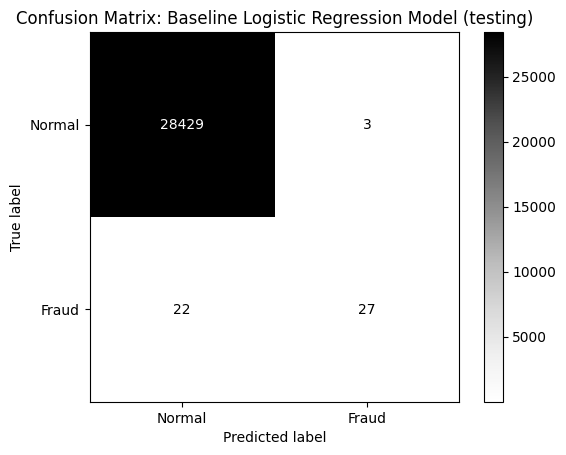

In [11]:
baseline_test_metrics = eval(y_test, model1.predict(X_test), kind= 'test', model_name= 'Baseline')

*The accuracy scores are near-perfect. This would imply that our model is performing exceptionally well. However, a look at other metrics of recall, precision and the f1-score, and the confusion matrix immediately shows the truth.*

    Accuracy = CorrectPredictions/TotalPredictions

*As it can be seen, the more the number of correct predictions, the higher is the accuracy. Due to the heavy class imbalance present in the dataset, the correct predictions are totally overshadowed by the Normal Transactions, thus inflating the scores and not reflecting the amount of incorrect predictions made in case of the Fraud Transactions, thus showing that accuracy cannot be used as the sole indicator of a model's performance, particularly in the case of class imbalance.*'


*On the other hand, Recall, Precision and F1-Score reveal the true story.*

    Recall = TP/(TP+FN), Precision = TP/(TP+FP), F1-score = 2*Recall*Precision/(Recall + Precision)

    where TP-> True Positives, FP= False Positives and FN= False Negatives



*For Fraud Cases (label 1), the model has a test-precision of 0.90 and a test recall of 0.55 for the 'Fraud' class. This indicates that while the number of false positives, i.e., Normal transactions labelled as Fraud, is low (which is a given due to the huge imbalance), the false negatives, i.e., Fraud Transactions labelled as Normal, is quite high, pushing both the Recall, and thus, the F1-score down.*

*This might be due to the model not seeing as much Fraud samples as it did for Normal ones, and thus when encountered with unseen samples, it would think of them belonging to the normal class, thus mislabeling them. As such, these metrics are able to show the actual performance of the model on a per class basis, indicating the whole view, and thus, are necessary for proper model analysis.*



*Thus, it can be concluded that a baseline model is still able to find a suitable balance between the Precision and Recall. For cases such as Fraud detection, it is more costly to consider Frauds as Normal than the vice versa, due to the costs of reimbursements and potential lawsuits. As such, in such a scenario, an ideal would be to increase the recall on the Fraud Transactions, lowering the number of misclassifications as Normal, even if it comes at a slight cost of a lowered precision. As such, the baseline could be improved more by keeping the precision roughly the same and bettering the recall.*

## B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### Theoretical Foundation

**Fundamental Difference between GMM-based Synthetic Sampling and naive methods like SMOTE**

*Methods such as the Synthetic Sampling from Gaussian Miture Model differ significantly from sampling methods such as SMOTE based on the underlying logic used to generate the Samples. In naive methods, the synthetic points are generated in a neighbourhood consisting of some 'k' amount of the class samples. For example, in SMOTE, a point of the class to be sampled is selected, it's k nearest neighbours identified a line drawn from the point to each of the neihgbour, and from any one of the randomly chosen lines, a point is sampled. This process does not involve learning any underlying structure of the data, and thus, the points sampled might be noisy or missrepresentative of the class they were sampled for, as in the feature space, the sampled point might end up belonging to some other class or even be an invalid point.*

*On the other hand, GMM assumes that the population is distributed as some k-individual Gaussians, which it learns from the provided training data. As such, it has an idea of the underlying distribution of the class, from which the sampled points would match much more closer to the actual points.*

**Why GMM is theoretically better at capturing the underlying data distribution, especially when the minority class has multiple sub-groups or complex shapes in the feature space.**

*As explained earlier, where naive methods generate samples from information using just the training points, GMM learns the underlying distribution. It assumes the population to be subdivided as some k-different Gaussians, each of which will have a different center and spread. As such, it is able to better capture the minority data, which has multiple subgroups and complex shapes, as it is able to capture each of those individual subgroups and their complexities due to learning different Gaussians for each of them.*

### GMM Implementation

Getting the minority class and the majority class data

In [12]:
X_train_minority, y_train_minority = X_train[y_train == 1], y_train[y_train == 1]
X_train_majority, y_train_majority = X_train[y_train == 0], y_train[y_train == 0]

Selecting the number of components for the GMM

*The selection of the number of components for a GMM is made using metrics such as AIC (Akaike Information Criteria) and BIC (Bayesian Information Criteria), which measures how well the model fits the training data, and how complex the model is(i.e how many more components the GMM has).*

*AIC considers a model's ability to fit the training data well, and allows for the model to grow complex if necessary, however, it penalises the model if it grows too complex*

        AIC = -2ln(L) + 2k
        where k measures the number of components   and thus, AIC increases with k
        and L is the likelihood of observing the training data given the model we are using

*BIC is considerably stricter on the model's complexity, penalising more harshly when the model complexity is higher, particularly for large datasets. BIC prefers the model to be as simple as possible while capturing essential patterns.*

        BIC = -2ln(L) + kln(n)
        where the additional n means the number of training points, meaning the penalty increases with the number of training points

*For both of them, the value increases with the complexity, and as such, the aim is to choose the model which has the lowest AIC or BIC. Among each other, AIC allows for some complexity, and is useful for smaller datasets, while BIC focuses primarily on simplicity and on larger datasets.*

Calculating the AIC and BIC for all possible types of GMM covariances for 1-25 components

In [13]:
all_aic, all_bic = [], []
covars = ['full', 'tied', 'diag', 'spherical']
cluster_range = range(1, 26) # Setting a high range to see all possible values
for cov in covars:
    aic_scores, bic_scores = [], []
    for k in cluster_range:
        gmm = GaussianMixture(n_components= k, covariance_type= cov, random_state= 66)
        gmm.fit(X_train_minority)
        aic_scores.append(gmm.aic(X_train_minority))
        bic_scores.append(gmm.bic(X_train_minority))
    all_aic.append(aic_scores)
    all_bic.append(bic_scores)

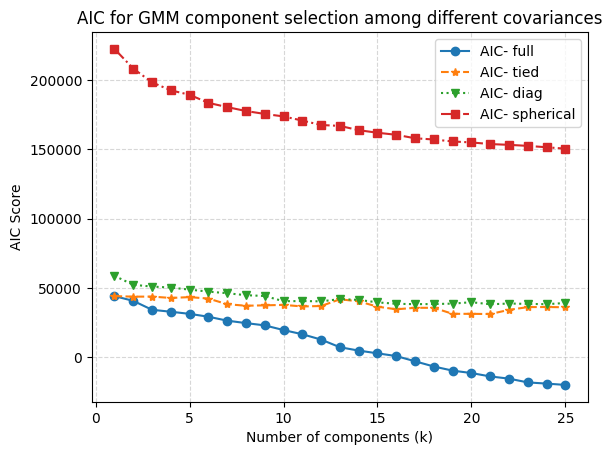

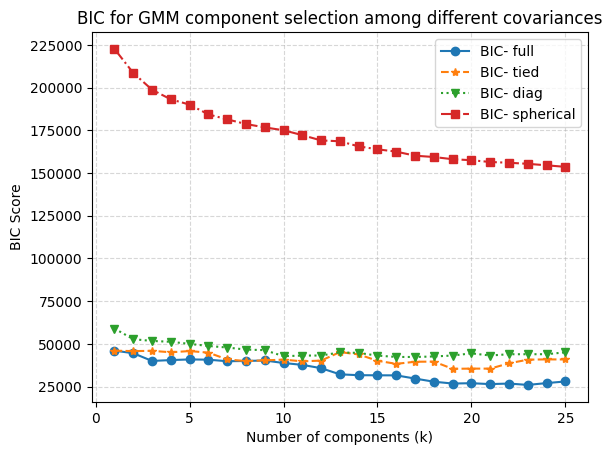

In [14]:
linestyles = ['-', '--', ':', '-.']
markers = ['o', '*', 'v', 's']
plt.figure()
for i, cov in enumerate(covars):
    plt.plot(cluster_range, all_aic[i], linestyles[i], marker= markers[i], label= f'AIC- {cov}')
plt.xlabel('Number of components (k)')
plt.ylabel('AIC Score')
plt.title('AIC for GMM component selection among different covariances')
plt.legend()
plt.grid(True, linestyle= '--', alpha= 0.5)
plt.show()  

plt.figure()
for i, cov in enumerate(covars):
    plt.plot(cluster_range, all_bic[i], linestyles[i], marker= markers[i], label= f'BIC- {cov}')
plt.xlabel('Number of components (k)')
plt.ylabel('BIC Score')
plt.title('BIC for GMM component selection among different covariances')
plt.legend()
plt.grid(True, linestyle= '--', alpha= 0.5)
plt.show()  


*The AIC keeps on decreasing, while the BIC, with few bumps and peaks, minimises at around 19-20 components and then begins to increase again.*

*Due to the lower number of datapoints and the relatively more leniency on complexity, the AIC keeps on lowering as the number of components are increased, meaning it is overfitting, as this means the GMM is assigining a unique Gaussian to each datapoint, missing the overall structure that is followed. As such, despite the dataset being small, BIC score will have to be used to select the number of components.*

*The BIC's penalty component of ln(n) would be small due to the small number of minority samples, and as such, it is majorly contributed by the number of components. As it can be seem, the BIC begins to increase after 20 components, meaning the ideal number of components <= 20*

*Among the various types of covariance matrices, spherical shows the highest BIC, which is a given as it assumes equal variance in all directions. Diag and Tied, are almost close, while the Full is the minimum. However, considering the number of datapoints, full covariance matrix, which assumes each cluster with own covariance, would introduce the most number of parameters, and might end up causing overfitting. As such, keeping the number of parameters in mind, I have selected the 'diag' variant, which assumes no covariance between features. Let us confirm this once.*

In [15]:
for i, cov in enumerate(covars):
    min_bic, min_bic_idx = min(all_bic[i]), all_bic[i].index(min(all_bic[i]))
    print(f'{cov} has Minimum BIC: {min_bic:.2f} at {min_bic_idx+1} components')

full has Minimum BIC: 25994.81 at 23 components
tied has Minimum BIC: 35430.17 at 19 components
diag has Minimum BIC: 42343.54 at 17 components
spherical has Minimum BIC: 153638.02 at 25 components


*Let's go with a Diag covaraince with 17 components. This way, each Gaussian will have a different covariance, and yet enough the score is minimum enough to justify selecting it.*

In [22]:
gmm = GaussianMixture(n_components= 17, covariance_type= 'diag', random_state= 66)
gmm.fit(X_train_minority)

,n_components,17
,covariance_type,'diag'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,66


### Synthetic Data Generation

*To generate the data, we would have to sample from the GMM. The GMM has say, k-components (i.e. k indiviudal Gaussians), each with their own mean, covariance matrix and probability of being chosen.*

*For sampling, one of these k Gaussians is chosen based on their probability of being chosen. From this selected Gaussian, a random sample is drawn from the distribution defined by the Gaussian's mean and covariance matrix. This is done for as many times as the number of samples needed.*

*Such samples have distribution which resembles the distribution learned by the GMM, and thus, is close to the underlyind real distribution, assumed as a multimodal Gaussian.*

Sampling from the GMM


*Another factor is the number of points to upsample the minority too. We need enough samples so that the data is represented well vs the majority, while at the same time, the model should not overfit. As such, various ratios are tried. Final selection will be done after evaluation on test*

In [23]:
ratios = [1, 0.5, 0.25, 0.10, 0.05, 0.01]
X_gmm_all, y_gmm_all = [],  []
for ratio in ratios:
    n_samples_gmm = int(len(y_train_majority)* ratio )

    X_gmm, _ = gmm.sample(n_samples_gmm)
    y_gmm = np.ones((n_samples_gmm, ), dtype= int) 

    # Combining with the original training data
    X_train_gmm = np.vstack([X_train_majority, X_gmm])
    y_train_gmm = np.hstack([y_train_majority, y_gmm])
    X_train_gmm, y_train_gmm = shuffle(X_train_gmm, y_train_gmm, random_state= 66) # Shuffling the data
    
    X_gmm_all.append(X_train_gmm)
    y_gmm_all.append(y_train_gmm)

### Rebalancing with CBU

Identifying number of clusters in the majority class samples

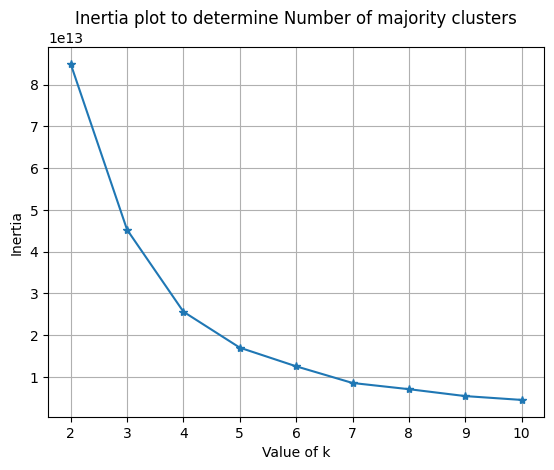

In [24]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters= k, random_state= 66)
    kmeans.fit_predict(X_train_majority)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(range(2, 11), inertia, '-*')
plt.grid(True)
plt.xlabel('Value of k')
plt.ylabel('Inertia')
plt.title('Inertia plot to determine Number of majority clusters')
plt.show()

*As inertia change diminishes after k=5, we choose 5 as the elbow, and thus consider 5 clusters*

In [25]:
kmeans = KMeans(n_clusters= 5, random_state= 66)
majority_clusters = kmeans.fit_predict(X_train_majority)
for k in range(5):
    mask = (majority_clusters == k)
    print(k+1, sum(mask))


1 48127
2 49307
3 45740
4 47329
5 14203


Undersampling to create new dataset

*All clusters but cluster 5 have around 50K points. As such, most representation comes from these clusters and the resampling will have to done accordingly*

In [26]:
ratios_cbu = [0.5, 0.25, 0.10, 0.05, 0.01]
X_cbu_all, y_cbu_all = [], []

# Trying out different ratios to downsample to
for ratio in ratios_cbu:
    X_cbu, y_cbu = [], []
    target = int(ratio * len(X_train_majority))
    # print(ratio, target)
    for k in range(5):
        mask = (majority_clusters == k)
        X_cluster = X_train_majority[mask]
        y_cluster = y_train_majority[mask]
        # Number of samples to choose based on the weight of the cluster
        n_samples = int((len(X_cluster)/len(X_train_majority))*target)
        if n_samples < 1: 
            # incase a cluster ends up giving no points
            continue
        X_res, y_res = resample(X_cluster, y_cluster, n_samples= n_samples, 
                                replace= False, random_state= 66)

        X_cbu.append(X_res)
        y_cbu.append(y_res)

    # combine all the oversampling results
    X_train_cbu = np.vstack(X_cbu)
    y_train_cbu = np.hstack(y_cbu)

    # GMM Sampling from the minority class
    # Upsampling to the size of 'Normal' Class
    n_samples_gmmcbu = len(X_train_cbu)
    X_gmmcbu, _ = gmm.sample(n_samples_gmmcbu)
    y_gmmcbu = np.ones((n_samples_gmmcbu, ), dtype= int) 

    # Combined Training Data
    X_train_gmmcbu = np.vstack([X_train_cbu, X_gmmcbu])
    y_train_gmmcbu = np.hstack([y_train_cbu, y_gmmcbu])
    X_train_gmmcbu, y_train_gmmcbu = shuffle(X_train_gmmcbu, y_train_gmmcbu, random_state= 66)
    # print(len(X_train_gmmcbu), len(X_train_cbu), len(X_gmmcbu))
    X_cbu_all.append(X_train_gmmcbu)
    y_cbu_all.append(y_train_gmmcbu)

## C: Performance Evaluation and Conclusion

### Model Training and Evaluation

Evaluation is on the imbalanced test data, by models trained on the balanced training data

#### Model 2: GMM Only

Finding the ideal model

In [27]:
import warnings # to ignore the ConvergenceWarnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

for idx, ratio in enumerate(ratios):
    model_check = LogisticRegression(max_iter= 1000, random_state= 66)
    model_check.fit(X_gmm_all[idx], y_gmm_all[idx])
    print(f'******Val Performance at Upsampling Ratio: {ratio}*****')
    print(f'Precision on "Fraud": {precision_score(y_val, model_check.predict(X_val.values)):.2f}')
    print(f'Recall on "Fraud": {recall_score(y_val, model_check.predict(X_val.values)):.2f}')
    print(f'F1 on "Fraud": {f1_score(y_val, model_check.predict(X_val.values)): .2f}')

warnings.filterwarnings('default', category=ConvergenceWarning) # setting back to default

******Val Performance at Upsampling Ratio: 1*****
Precision on "Fraud": 0.07
Recall on "Fraud": 0.92
F1 on "Fraud":  0.13
******Val Performance at Upsampling Ratio: 0.5*****
Precision on "Fraud": 0.11
Recall on "Fraud": 0.89
F1 on "Fraud":  0.20
******Val Performance at Upsampling Ratio: 0.25*****
Precision on "Fraud": 0.16
Recall on "Fraud": 0.87
F1 on "Fraud":  0.27
******Val Performance at Upsampling Ratio: 0.1*****
Precision on "Fraud": 0.37
Recall on "Fraud": 0.85
F1 on "Fraud":  0.51
******Val Performance at Upsampling Ratio: 0.05*****
Precision on "Fraud": 0.60
Recall on "Fraud": 0.84
F1 on "Fraud":  0.70
******Val Performance at Upsampling Ratio: 0.01*****
Precision on "Fraud": 0.66
Recall on "Fraud": 0.82
F1 on "Fraud":  0.73


*As we decrease the upsampling ratio, the precision goes up, while the Recall goes down. However, the precision goes up way faster than the recall goes down. Even so, in our case, a high recall means lower False Negatives i.e. lower number of Frauds misclassified as Normal transactions, and thus as described earlier that these False Negatives are more costly than the False Positives due to possible reimbursements, associated costs of later detection and lawsuits, the model should focus on increasing the recall as much as possible. However, a higher Precision also corresponds to lower number of False Positives, i.e, Normal transactions flagged as Fraud. Due to the high amount of Normal Transactions, a small Precision value could lead to high costs in investigating these False Positives. As such, an ideal case would be a very high Recall and an above 0.5 precision. For the same, the upsampling ratio of 0.05 provides the best tradeoff here, and thus, is selected.*

Training

In [28]:
best_ratio_gmm = ratios.index(0.05)
X_train_gmm, y_train_gmm = X_gmm_all[best_ratio_gmm], y_gmm_all[best_ratio_gmm]

model2 = LogisticRegression(max_iter= 1000, random_state= 66)
model2.fit(X_train_gmm, y_train_gmm)

/home/devashish623/devashish/defvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,66
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Evaluation on Test Data

**Results: GMM Logistic Regression Model (testing)**
Overall Accuracy:  0.999
Precision on 'Fraud' class:  0.639
Recall on 'Fraud' class:  0.796
F1-Score on 'Fraud' class:  0.709
**Classification Report: GMM Logistic Regression Model (testing)**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.64      0.80      0.71        49

    accuracy                           1.00     28481
   macro avg       0.82      0.90      0.85     28481
weighted avg       1.00      1.00      1.00     28481



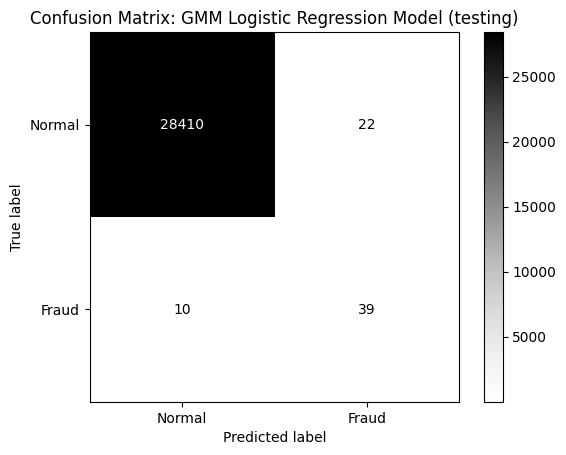

In [29]:
GMM_test_metrics = eval(y_test, model2.predict(X_test.values), kind= 'test', model_name= 'GMM')

*With a recall of 0.80 and precision of 0.64, GMM-based upsampling provides the best results, when upsampled to 5% of the size of the majority class. Due to the high size of the majority class, this ends up introducing a lot of samples to the minority class, where while it still remains in the minority, the samples, generated from the GMM, provide enough information to the model to distinguish well between the Frauds and the Normals, provide an adequate balance between the Recall and the Precision. The generated samples, do not completely overshadow the training data due to their count and yet are sufficient enough for the Logistic Regression to generalise to and find a decision boundary in the feature space. Thus, diversity is maintained in the samples, which translates to the results on the untouched test data.*

#### Model 3: GMM + CBU

*As in the above case, we also need to determine the ideal number of points to downsample the majority class to, so that it is still well represented in the dataset while not being overwhelmed by the upsampled minority class and is able to provide a valid tradeoff between the recall and the precision*

In [30]:
import warnings # to ignore the ConvergenceWarnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

for idx, ratio in enumerate(ratios_cbu):
    model_check_cbu = LogisticRegression(max_iter= 1000, random_state= 66)
    model_check_cbu.fit(X_cbu_all[idx], y_cbu_all[idx])
    print(f'******Val Performance at Ratio of samples left after downsampling to {ratio} of original:*****')
    print(f'Precision on "Fraud": {precision_score(y_val, model_check_cbu.predict(X_val.values)):.4f}')
    print(f'Recall on "Fraud": {recall_score(y_val, model_check_cbu.predict(X_val.values)):.4f}')
    print(f'F1 on "Fraud": {f1_score(y_val, model_check_cbu.predict(X_val.values)): .4f}')

warnings.filterwarnings('default', category=ConvergenceWarning) # setting back to default

******Val Performance at Ratio of samples left after downsampling to 0.5 of original:*****
Precision on "Fraud": 0.0713
Recall on "Fraud": 0.9213
F1 on "Fraud":  0.1324
******Val Performance at Ratio of samples left after downsampling to 0.25 of original:*****
Precision on "Fraud": 0.0692
Recall on "Fraud": 0.9213
F1 on "Fraud":  0.1287
******Val Performance at Ratio of samples left after downsampling to 0.1 of original:*****
Precision on "Fraud": 0.0756
Recall on "Fraud": 0.9101
F1 on "Fraud":  0.1395
******Val Performance at Ratio of samples left after downsampling to 0.05 of original:*****
Precision on "Fraud": 0.0746
Recall on "Fraud": 0.9213
F1 on "Fraud":  0.1380
******Val Performance at Ratio of samples left after downsampling to 0.01 of original:*****
Precision on "Fraud": 0.0595
Recall on "Fraud": 0.9213
F1 on "Fraud":  0.1118


*It seems that the more we downsample, the worser the precision gets, with only a marginal change in the recall. This significant drop in precision can be explained as follows. When the downsampling ratio is relatively high (say 0.5), due to the large size of the dataset, and the fact that we bring up the number of minority samples, we end up getting too many minority samples, which all are generated from a GMM made from just the original training class majority samples. This GMM, made from very few training points, results in minority samples which in such a high quantity, end up making the model overfit. As we decrease the number of majority samples to keep, we also decrease the number of minority samples generated, leading to the model knowing less and less about both the classes, wherein it doesn't get to learn how to distinguish between a Normal and a Fraud sample, leading to many misclassifications of Normal as Frauds, causing the low precision.  Downsampling to 10% of the original size gives the 'highest' f1-score. So, the relatively best ratio is 0.10.*

Training

In [31]:
best_ratio_cbu = ratios_cbu.index(0.10)
X_train_gmmcbu, y_train_gmmcbu = X_cbu_all[best_ratio_cbu], y_cbu_all[best_ratio_cbu]
model3 = LogisticRegression(max_iter= 1000, random_state= 66)
model3.fit(X_train_gmmcbu, y_train_gmmcbu)

/home/devashish623/devashish/defvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,66
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Evaluation on test

**Results: GMM+CBU Logistic Regression Model (testing)**
Overall Accuracy:  0.981
Precision on 'Fraud' class:  0.071
Recall on 'Fraud' class:  0.837
F1-Score on 'Fraud' class:  0.131
**Classification Report: GMM+CBU Logistic Regression Model (testing)**
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28432
           1       0.07      0.84      0.13        49

    accuracy                           0.98     28481
   macro avg       0.54      0.91      0.56     28481
weighted avg       1.00      0.98      0.99     28481



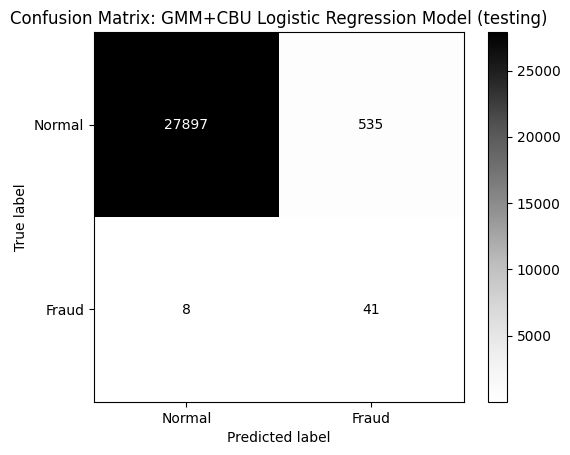

In [32]:
GMMCBU_test_metrics = eval(y_test.values, model3.predict(X_test.values), kind= 'test', model_name= 'GMM+CBU')

*CBU followed by GMM-based sampling, no matter the downsampling ratio, results in a poor precision score but a very high recall. For the case we have taken, the recall is around 0.84 while the precision is just 0.07. This shows that when we downsampled the points of the majority class, we lost information distinguishing them from the Fraud samples, as it is evident from the Confusion Matrix and the classification report that the model is still able to classify them well. But due to the significantly higher proportion of the Fraud class samples in the training dataset, as these samples were sampled from the GMM trained on the few minority points, they quite possibly incur noise and show similar feature values, leading the model to overfit on the training data, where while it learns how the Fraud samples look, it is not able to distinguish between the Fraud and the Normal transactions and thus, is misclassifying too many Normal transactions as Frauds. While the number of False Negatives is down, this will cause the Recall to go high, the high number of False Positives will still incur costs for the company.*

### Comparative Analysis

Result comparison among all the three models across all metrics (for the minority class)

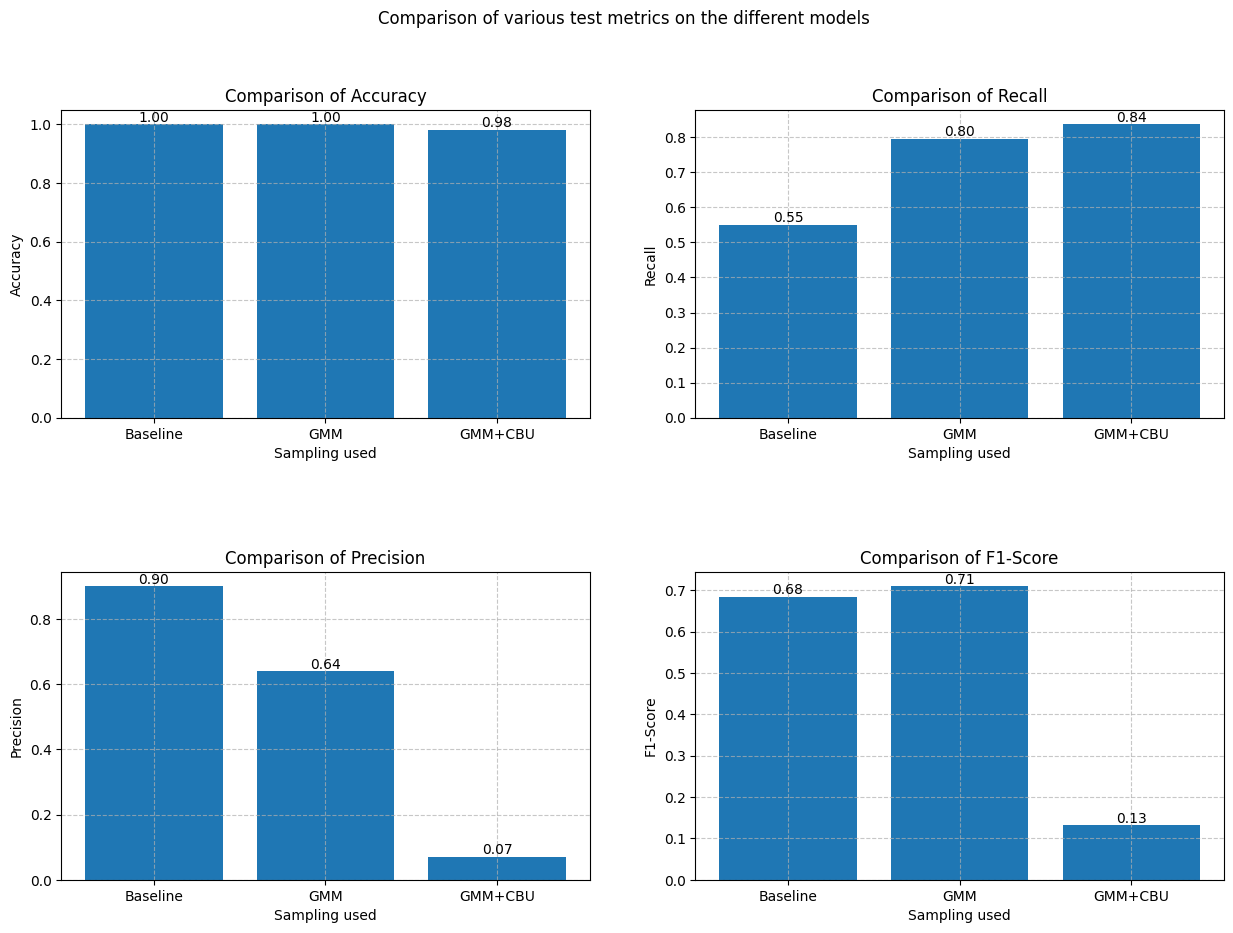

In [33]:
test_metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
models = ['Baseline', 'GMM', 'GMM+CBU']
fig, axes = plt.subplots(2, 2, figsize= (15, 10))
plt.subplots_adjust(hspace=0.5) # Increase vertical spacing
m = 0     # counter

for i in range(2):
    for j in range(2):
        toplot = [baseline_test_metrics[m], GMM_test_metrics[m], GMMCBU_test_metrics[m]]
        ax = axes[i][j]
        ax.set_title(f'Comparison of {test_metrics[m]}')
        ax.set_xlabel('Sampling used')
        ax.set_ylabel(test_metrics[m])
        p = ax.bar(models, toplot, )
        ax.bar_label(p, label_type= 'edge', fmt= '%.2f')
        ax.grid(True, 'both', linestyle= '--', alpha= 0.7)
        m += 1

plt.suptitle('Comparison of various test metrics on the different models')
plt.show()

**Impact of GMM-based oversampling on the classifier's performance**

*GMM-based oversampling allowed the classifier to get more information about the minority class, as these points came from Gaussians estimated to capture in the best possible manner, the underlying distribution of the minority class data. Additionally, through experimentation on the test data in both GMM and GMM+CBU cases, it was discovered that the number of points upsampled AND the size distribution of the new training data also matter significantly. In the former case, the majority samples remained the same and among all the upsamplings tried, the best results were given by upsampling to 5% of the majority's size. Yet, in all of them, recall was increased as the model got more samples to get to learn the minority class from, even if it overfit in many cases. Similar could be said for the latter case, where the change in the size of the majority class made it much more easier to overfit on the less diverse generated minority points. Yet the recall was high.*
 


**As such, the model's capability to detect the minority increased with GMM-based synthetic sampling, but so did its tendency to misclassify Normal samples and Fraudulent, implying the factor of the training data size distribution playing a key role in getting the best possible trade-off between the Precision and Recall.**

### Final Recommendation

*For our task case, we had to make the classifier to predict the Fraud transactions using a dataset which was very heavily imbalanced by Normal Transactions. In such cases, misclassifying Frauds as Normal (False Negatives) could result in huge costs, including but not limited to reimbursements to be made for the Frauds, the cost of rechecks and potential lawsuits. In comparison, the costs of misclassifying Normal as Frauds include just rechecking. Thus, for our usecase, we prefer to have a high recall and an above average precision.*

*On the baseline model, we had a high precision of 0.90 but a mediocre recall of 0.55, resulting in an F1-score of 0.68. Our problem statement led us to focus on increasing the recall while maintaining a suitably high precision. The reason being a high recall corresponds to lower number of False Negatives, and a high precision corresponds to a lower number of False Positives. Thus, while the performance is fine, it is not a suitable model for this task.*

*On the other hand, when we used GMM to generate the minority class points to 5% of the size of the majority class, due to the huge number of majority samples, this resulted in a diverse representation, which while still dominated by the majority class, had enough information about the minority class that the model was able to distinguish between both the classes fairly well, while achieving a high recall of 0.80 and a satisfactory precision of 0.64, earning an f1-score of 0.71, which is the highest among all three approaches, showcasing the best possible balance maintained between Recall and Precision when giving more importance to Recall.*

*Finally, we tried to downsample the majority class samples using CBU and generate the minorities using GMM. This led to both classes having an equal number of samples. In our case where we downsampled the majority to 10% of the initial size, we got the highest recall of 0.84, but a very low precision of 0.07, implying the model is able to lower the number of False Negatives fairly well, while failing to distinguish Normal class samples from Fraud, causing a low precision.*

*While the recall is the highest in the CBU+GMM method, using only GMM to generate the points results in the best possible tradeoff between the Precision and Recall. GMM proves effective for synthetic data generation, given on conditions such as the number of samples generated, the number of training samples used and the kind of covariance matrix utilised, along with the size of the majority class. For our case, the number of training samples was low, leading us to use the Diagonal Covariance matrices to prevent any overfitting while still allowing the Gaussians to be different. And we generated enough synthetic samples to provide the model information about the minority class to create a good decision boundary while not skewing the distribution very much, leading to the best possible tradeoff between Recall and Precision.*

**Thus the final recommendation for this task is using GMM-based synthetic generation of the minority class points to 5% of the size of the majority, where there are 17 Gaussians having diagonal covariance matrices**